<h1 ><big><center>Foundations of Distributed and Large Scale Computing Optimization</center></big></h1>


<h2><big><center> Proximal Denoising </center></big></h2>

***


**STUDENT**:  Plassier Vincent

**EMAIL**: vincent.plassier@ens-paris-saclay.fr

***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import os
from scipy.optimize import fmin

path = os.getcwd() + "/florence.jpg"
print(os.path.exists(path))

True


### Question 3:

In [2]:
img = plt.imread(path)
img_size = np.shape(img)

sigma = 30
w = img + np.random.normal(0, sigma, img_size)
img_noisy = (w - np.min(w))/(np.max(w) - np.min(w))

Let's start by displaying the original image as well as the noisy one. In the beginning, we run the code with the ** SNR ** indicator rather than the mean squared loss.

Text(0.5,1,'Noisy image, SNR=9.43491 dB')

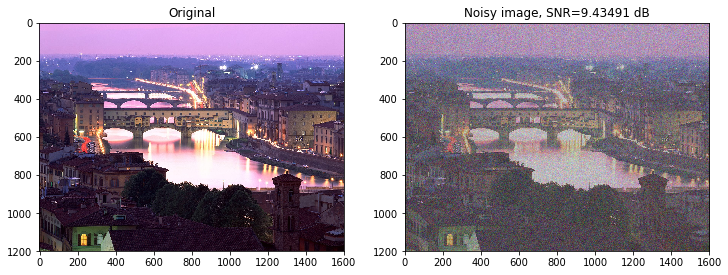

In [3]:
SNR = lambda f, f_M : int(20 * np.log10(np.linalg.norm(f) / np.linalg.norm(f-f_M)) * 10e4)/10e4
# If we prefer to display the quadratic error: lambda f, f_M : np.mean((f-f_M)**2)

img = (img - np.min(img))/(np.max(img) - np.min(img))

plt.figure(1)
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img)
plt.title('Original')
plt.subplot(222)
plt.imshow(img_noisy)
plt.title('Noisy image, SNR=%s dB' %(SNR(img,img_noisy)))

### Question 4

The cell below contains the proximal operators for the different values of * q *.

In [4]:
def prox1(z, Chi):
    return np.sign(z) * np.maximum(np.abs(z) - Chi, 0)

def prox43(z, Chi):
    a = np.sqrt(np.power(z, 2) + 256 * (Chi ** 3 ) / 729)
    return z + ((4 * Chi) / (3 * np.power(2, 1/3))) * np.power(a - z, 1 / 3) - np.power(a + z, 1 / 3)

def prox32(z, Chi):
    return z + 9/8 * Chi**2 * np.sign(z) * (1 - np.sqrt(1 + (16 * np.abs(z)) / (9 * Chi ** 2)))

def prox2(z, Chi):
    return z / (1 + 2 * Chi)

def prox3(z, Chi):
    return np.sign(z) * (np.sqrt(1 + 12 * Chi * np.abs(z)) - 1) / (6 * Chi)

def prox4(z, Chi):
    a = np.sqrt(np.power(z, 2) + (1 / (27 * Chi)))
    return np.power((a + z) / (8 * Chi), 1/3) - np.power((a - z) / (8 * Chi), 1/3)

We define the set of values taken by * q * and *prox*:

In [5]:
q_set = [1, 4/3, 3/2, 2, 3, 4]
prox_set = [prox1, prox43, prox32, prox2, prox3, prox4]

The * img_denoising * algorithm is used in the denoising of the image.

In [6]:
def img_denoising(img_noisy, prox, Chi):
    fw = pywt.wavedec2(img_noisy, wavelet='db8', mode='symmetric', axes=(0, 1), level=4)
    for i,x in enumerate(fw[1:]):
        fw[i+1] = prox(x, Chi)
    img_denoised =  pywt.waverec2(fw, wavelet='db8', mode='symmetric', axes=(0, 1))
    return (img_denoised - np.min(img_denoised)) / (np.max(img_denoised)-np.min(img_denoised))

We display an example obtained thanks to our algorithm.

Text(0.5,1,'Denoised image, SNR=15.98632 dB')

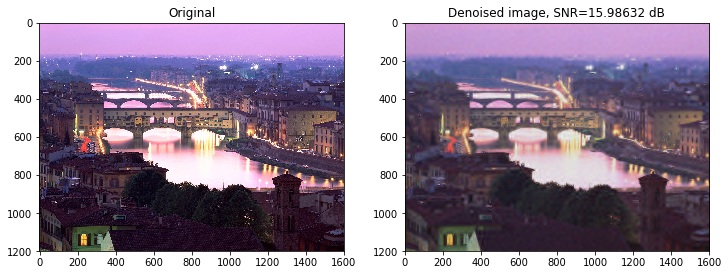

In [7]:
img_d = img_denoising(img_noisy, prox_set[0], .19)

plt.figure(2)
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img)
plt.title('Original')
plt.subplot(222)
plt.imshow(img_d)
plt.title('Denoised image, SNR=%s dB' %(SNR(img, img_d)))

The following algorithm allows to find * Chi * optimal.

Optimization terminated successfully.
         Current function value: -15.987800
         Iterations: 15
         Function evaluations: 30


Text(0.5,1,'Evolution de la SNR en fonction de Chi')

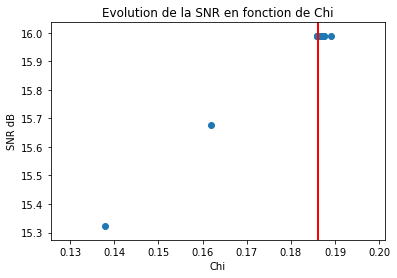

In [10]:
Chi = .12
prox = prox_set[0]

def func(Chi):
    img_denoised = img_denoising(img_noisy, prox, Chi)
    return -SNR(img, img_denoised)

I = []
liste = lambda x : I.append([x,-func(x)])
Chi_min = fmin(func, Chi, callback = liste)[0]
I = np.array(I)

plt.figure(3)
plt.scatter(I[:,0], I[:,1])
plt.axvline(x=Chi_min, ymin=0, ymax = 1, linewidth=2, color='r')
plt.xlabel('Chi')
plt.ylabel('SNR dB')
plt.title('Evolution de la SNR en fonction de Chi')

Finally, we display the evolution of the mean square error according to the * Chi * parameter.

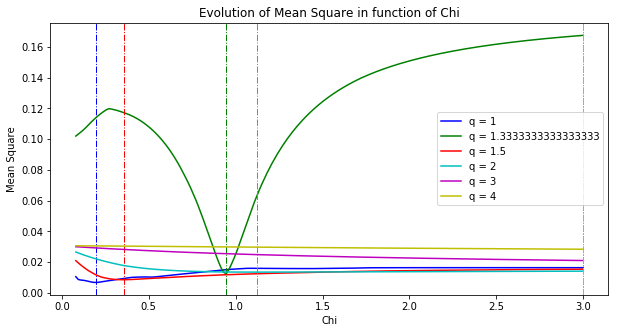

In [9]:
Chi_list = np.linspace(8*1e-2, 3, 200)
Chi_Best = np.zeros(len(q_set))
err = np.zeros((len(q_set), len(Chi_list)))
fc = lambda f, f_M : np.mean((f-f_M)**2)

for i in range(len(q_set)):
    prox = prox_set[i]
    mse = np.inf
    for j, Chi in enumerate(Chi_list):
        img_d = img_denoising(img_noisy, prox, Chi)
        err[i,j] = fc(img, img_d) # SNR(img, img_d)
        if err[i,j] < mse:
            Chi_Best[i] = Chi
            mse = err[i,j]

ColorStyle= ['b', 'g', 'r', 'c', 'm', 'y']
plt.figure(4)
plt.figure(figsize=(10,5))
for i in range(len(q_set)):
    plt.plot(Chi_list, err[i], color=ColorStyle[i], label='q = %s' %(q_set[i]))
    plt.axvline(x=Chi_Best[i], ymin=0, ymax=1, color=ColorStyle[i], linewidth=1, linestyle='-.')
plt.axis('tight')
plt.xlabel('Chi') 
plt.ylabel('Mean Square')
plt.title('Evolution of Mean Square in function of Chi')
plt.legend()